In [436]:
import pandas as pd
import numpy as np
from plotnine import *

%load_ext lab_black

ModuleNotFoundError: No module named 'scales'

In [355]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/MIDS-at-Duke/estimating-impact-of-opioids-2020-purlple-team/TommyTseng/20_intermediate_files/2006-2012_prescription.csv?token=ARFW6V5L4YGBDF5CM3QKSXC7SXUCU"
)
pop = pd.read_csv(
    "https://raw.githubusercontent.com/MIDS-at-Duke/estimating-impact-of-opioids-2020-purlple-team/ssloate/20_intermediate_files/countypopulations_clean.csv?token=ARFW6VYROFILNMBNR2ENMEK7SXUKK"
)
fips = pd.read_excel(
    "/Users/samsloate/Desktop/Data_Science/Opioids_Project/estimating-impact-of-opioids-2020-purlple-team/00_source/fips_codes.xlsx"
)

In [356]:
data = data.copy()
pop = pop.copy()
fips = fips.copy()
data = data.rename(
    columns={"BUYER_STATE": "State", "BUYER_COUNTY": "County", "YEAR": "Year"}
)

In [357]:
# change County columns to sentence case and add the word county at the end
data["County"] = data["County"].str.capitalize()

# add County to end
data["County"] = data["County"] = data["County"] + " County"

# change fips column name to match County
fips = fips.rename(columns={"Full Name": "County"})

# drop _merge column in pop
pop = pop.drop(columns="_merge")

In [358]:
# drop Alaska (Nick said to) and Louisiana (we know they aren't a match based on other graphing)
data = data[data["State"] != "AK"]
data = data[data["State"] != "LA"]
fips = fips[fips["State"] != "AK"]
fips = fips[fips["State"] != "LA"]


# make new fips dataset for only the states we have in the shipment dataset
fips_cut = fips.loc[fips["State"].isin(list(data["State"].unique()))]

# check it's the right length / has all states
assert len(fips_cut.State.unique()) == len(list(data["State"].unique()))

In [359]:
# merge data
merged = pd.merge(fips_cut, data, on=["County", "State"], how="outer", indicator=True)

In [360]:
# fix inaccuracies

data["County"].replace("De kalb County", "De Kalb County", inplace=True)
data["County"].replace("Dekalb County", "De Kalb County", inplace=True)
data["County"].replace("Saint clair County", "St. Clair County", inplace=True)
data["County"].replace("Hot spring County", "Hot Spring County", inplace=True)
data["County"].replace("Little river County", "Little River County", inplace=True)
data["County"].replace("Saint francis County", "St. Francis County", inplace=True)
data["County"].replace("Van buren County", "Van Buren County", inplace=True)
data["County"].replace("Desoto County", "De Soto County", inplace=True)
data["County"].replace("De soto County", "De Soto County", inplace=True)
data["County"].replace("Indian river County", "Indian River County", inplace=True)
data["County"].replace("Miami-dade County", "Miami-Dade County", inplace=True)
data["County"].replace("Palm beach County", "Palm Beach County", inplace=True)
data["County"].replace("Saint johns County", "St. Johns County", inplace=True)
data["County"].replace("Saint lucie County", "St. Lucie County", inplace=True)
data["County"].replace("Santa rosa County", "Santa Rosa County", inplace=True)
data["County"].replace("Ben hill County", "Ben Hill County", inplace=True)
data["County"].replace("Jeff davis County", "Jeff Davis County", inplace=True)
data["County"].replace("Pearl river County", "Pearl River County", inplace=True)
data["County"].replace("Mcdowell County", "McDowell County", inplace=True)
data["County"].replace("New hanover County", "New Hanover County", inplace=True)
data["County"].replace("Mccormick County", "McCormick County", inplace=True)
data["County"].replace("Mcduffie County", "McDuffie County", inplace=True)
data["County"].replace("Mcintosh County", "McIntosh County", inplace=True)
data["County"].replace("Jefferson davis County", "Jefferson Davis County", inplace=True)


merged = pd.merge(fips_cut, data, on=["County", "State"], how="outer", indicator=True)
merged[merged["_merge"] != "both"]

,FIPS,County,State,State Name,Year,Total_Weight,_merge
1625,13053,Chattahoochee County,GA,Georgia,NaN,NaN,left_only
1787,13101,Echols County,GA,Georgia,NaN,NaN,left_only
2253,13239,Quitman County,GA,Georgia,NaN,NaN,left_only
2333,13265,Taliaferro County,GA,Georgia,NaN,NaN,left_only
2474,13307,Webster County,GA,Georgia,NaN,NaN,left_only
2713,28055,Issaquena County,MS,Mississippi,NaN,NaN,left_only
3190,37029,Camden County,NC,North Carolina,NaN,NaN,left_only
3415,37095,Hyde County,NC,North Carolina,NaN,NaN,left_only


In [361]:
# check that there's no weird misspellings of the counties or other obvious misaignments
ga_fips = list(fips[fips["State"].isin(["GA"])]["County"].unique())
ga_data = list(data[data["State"].isin(["GA"])]["County"].unique())
print(list(set(ga_fips) - set(ga_data)))

ms_fips = list(fips[fips["State"].isin(["MS"])]["County"].unique())
ms_data = list(data[data["State"].isin(["MS"])]["County"].unique())
print(list(set(ms_fips) - set(ms_data)))

nc_fips = list(fips[fips["State"].isin(["NC"])]["County"].unique())
nc_data = list(data[data["State"].isin(["NC"])]["County"].unique())
print(list(set(nc_fips) - set(nc_data)))

# the remaining counties are not in the original dataset, likely because they had no drug shipments. We are okay omitting these.

['Chattahoochee County', 'Webster County', 'Taliaferro County', 'Quitman County', 'Echols County']
['Issaquena County']
['Hyde County', 'Camden County']


In [367]:
# make final FIPS/drug shipment dataset
drugship = merged[merged["_merge"] == "both"]

assert (drugship._merge == "both").all()

# drop _merge column and reorder
drugship = drugship.drop(columns="_merge")
drugship = drugship[["State", "State Name", "County", "FIPS", "Year", "Total_Weight"]]
drugship.head()

,State,State Name,County,FIPS,Year,Total_Weight
0,AL,Alabama,Autauga County,1001,2006.0,17100.542225
1,AL,Alabama,Autauga County,1001,2007.0,19152.437289
2,AL,Alabama,Autauga County,1001,2008.0,21785.835290
3,AL,Alabama,Autauga County,1001,2009.0,24439.987693
4,AL,Alabama,Autauga County,1001,2010.0,26169.308158


In [411]:
# merge in population data. Use inner because not all states are in dataset

drug_pop = pd.merge(
    drugship, pop, on=["FIPS", "Year"], how="inner", validate="m:m", indicator=True
)
# check
assert (drug_pop._merge == "both").all()

# drop irrelevant columns
drug_pop = drug_pop.drop(
    columns=["County_x", "State Name_x", "Unnamed: 0", "State", "_merge"]
)
# rename colums
drug_pop = drug_pop.rename(columns={"State Name_y": "State", "County_y": "County"})

# reorder columns
drug_pop = drug_pop[
    ["State Abbr", "State", "County", "FIPS", "Year", "Total_Weight", "Population"]
]

In [415]:
# do some reasonableness checks
assert len(drug_pop["State"].unique()) == 7
assert (drug_pop["Total_Weight"] > 0).all
assert (drug_pop["Population"] > 0).all

In [419]:
# create drug shipment per capita column
# Create per capita deaths column
drug_pop["PerCapWeight"] = (drug_pop["Total_Weight"] / drug_pop["Population"]) * 100000

In [420]:
# create FL datasets

# Florida: pre and post 2010
FL_policy_year = 2010
FL = drug_pop[drug_pop["State Abbr"] == "FL"]
FL_pre = FL[FL["Year"] < FL_policy_year]
FL_post = FL[FL["Year"] >= FL_policy_year]

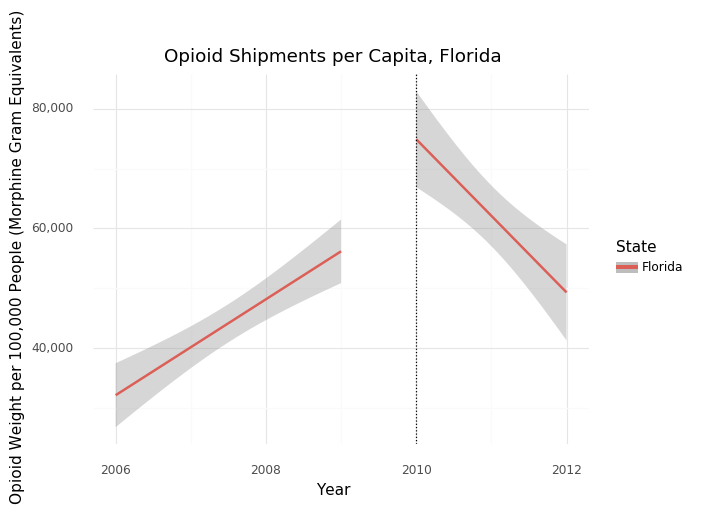

<ggplot: (8781432522985)>


In [451]:
# graph pre-post: Florida
p = (
    ggplot()
    + geom_smooth(FL_pre, aes(x="Year", y="PerCapWeight", color="State"), method="lm")
    + geom_smooth(
        FL_post,
        aes(x="Year", y="PerCapWeight", color="State"),
        method="lm",
    )
    + geom_vline(xintercept=FL_policy_year, linetype="dotted")
    + xlab("Year")
    + ylab("Opioid Weight per 100,000 People (Morphine Gram Equivalents)")
    + theme_minimal()
    + scale_x_continuous(breaks=[2006, 2008, 2010, 2012], limits=[2006, 2012])
    + labs(title="Opioid Shipments per Capita, Florida")
    + scale_y_continuous(
        breaks=[40000, 60000, 80000], labels=["40,000", "60,000", "80,000"]
    )
)

print(p)

In [452]:
ggsave(
    plot=p,
    filename="FL_opioid_shipments_pre_post",
    path="/Users/samsloate/Desktop/Data_Science/Opioids_Project/estimating-impact-of-opioids-2020-purlple-team/30_results",
    dpi=100,

SyntaxError: unexpected EOF while parsing (<ipython-input-452-85442d2c8472>, line 5)

Error in callback <bound method BlackFormatter.format_cell of <lab_black.BlackFormatter object at 0x7fc9714df750>> (for post_run_cell):


TokenError: ('EOF in multi-line statement', (6, 0))

In [457]:
# generate pre and post datasets in 2010, for Florida shipment DiD
states = drug_pop["State Abbr"].unique()
FL_df_pre = []
FL_df_post = []

# creates list of dataframes with pre 2010 data
for state in states:
    state_code = drug_pop[drug_pop["State Abbr"] == state]
    x = state_code[state_code["Year"] < FL_policy_year]
    # x will be a state for 2010 or lower years
    FL_df_pre.append(x)


# creates list of dataframes with post 2010 data
for state in states:
    state_code = drug_pop[drug_pop["State Abbr"] == state]
    x = state_code[state_code["Year"] >= FL_policy_year]
    # x will be a state for 2010 or lower years
    FL_df_post.append(x)

# create a list of the states
titles = drug_pop["State"].unique()
titles = titles.tolist()

# run checks
assert len(FL_df_pre) == len(FL_df_post)
assert len(FL_df_pre) == 7

/Users/samsloate/opt/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/samsloate/opt/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/samsloate/Desktop/Data_Science/Opioids_Project/estimating-impact-of-opioids-2020-purlple-team/30_results/FL_DID/Opioid Shipment: FL Alabama


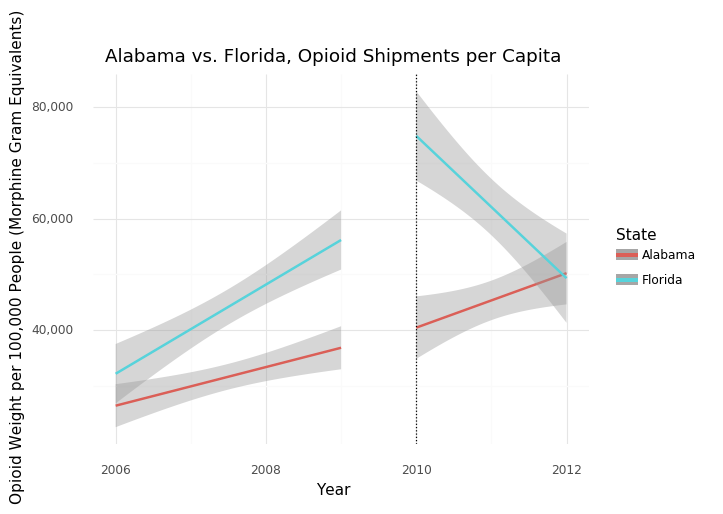

<ggplot: (8781429673201)>


/Users/samsloate/opt/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/samsloate/opt/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/samsloate/Desktop/Data_Science/Opioids_Project/estimating-impact-of-opioids-2020-purlple-team/30_results/FL_DID/Opioid Shipment: FL Arkansas


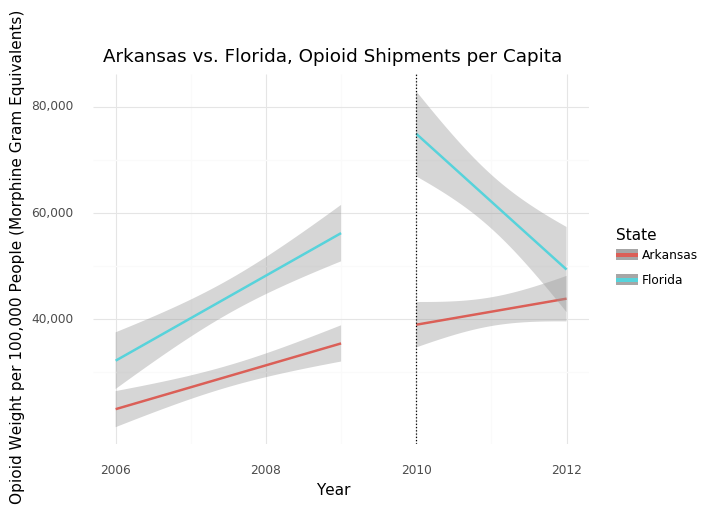

<ggplot: (8781429655385)>


/Users/samsloate/opt/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/samsloate/opt/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/samsloate/Desktop/Data_Science/Opioids_Project/estimating-impact-of-opioids-2020-purlple-team/30_results/FL_DID/Opioid Shipment: FL Florida


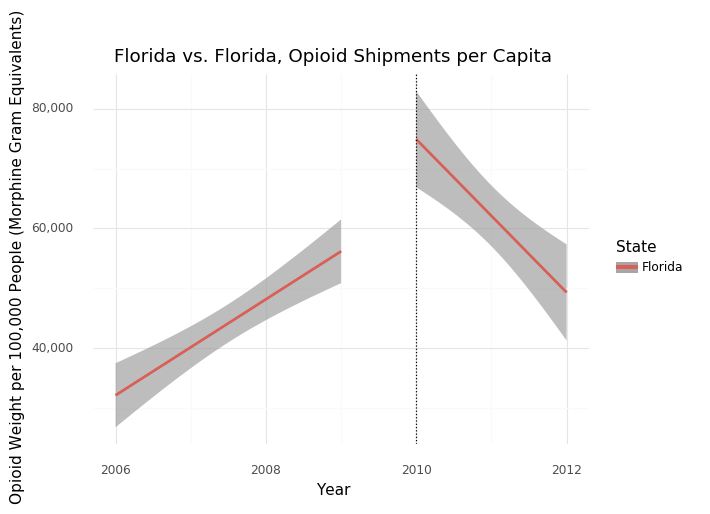

<ggplot: (8781432388401)>


/Users/samsloate/opt/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/samsloate/opt/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/samsloate/Desktop/Data_Science/Opioids_Project/estimating-impact-of-opioids-2020-purlple-team/30_results/FL_DID/Opioid Shipment: FL Georgia


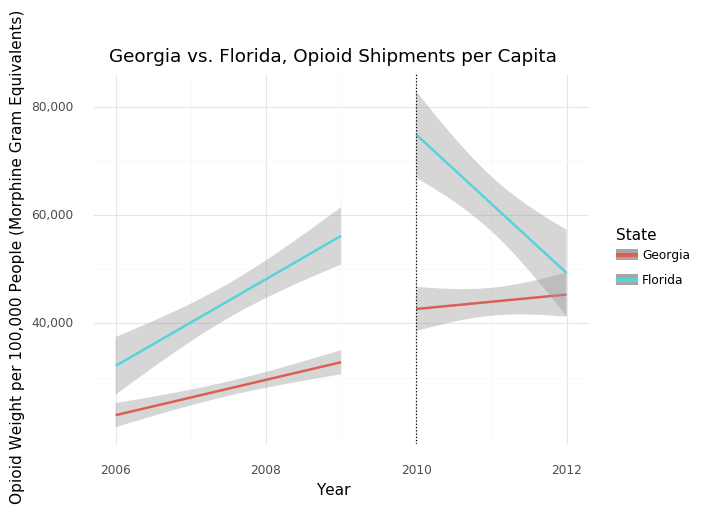

<ggplot: (8781429219429)>


/Users/samsloate/opt/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/samsloate/opt/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/samsloate/Desktop/Data_Science/Opioids_Project/estimating-impact-of-opioids-2020-purlple-team/30_results/FL_DID/Opioid Shipment: FL Mississippi


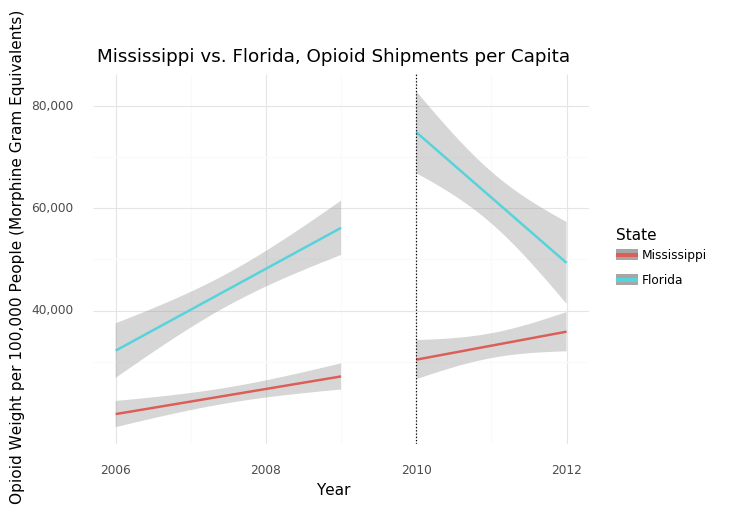

<ggplot: (8781434869405)>


/Users/samsloate/opt/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/samsloate/opt/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/samsloate/Desktop/Data_Science/Opioids_Project/estimating-impact-of-opioids-2020-purlple-team/30_results/FL_DID/Opioid Shipment: FL North Carolina


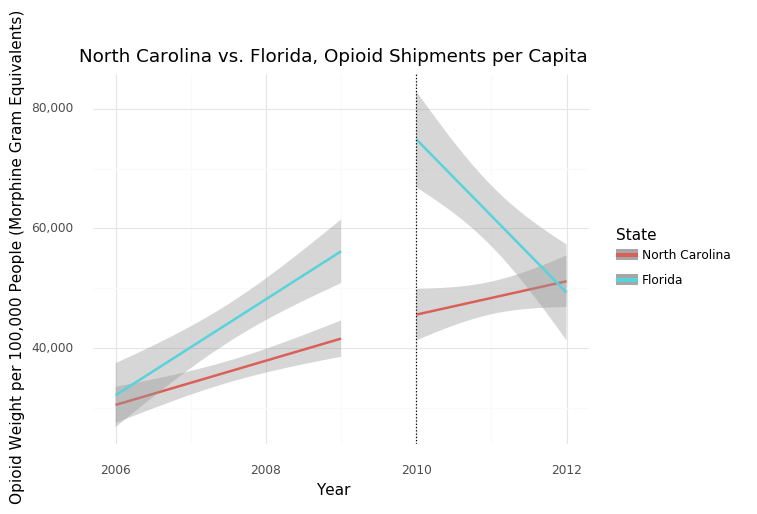

<ggplot: (8781427178785)>


/Users/samsloate/opt/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/samsloate/opt/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/samsloate/Desktop/Data_Science/Opioids_Project/estimating-impact-of-opioids-2020-purlple-team/30_results/FL_DID/Opioid Shipment: FL South Carolina


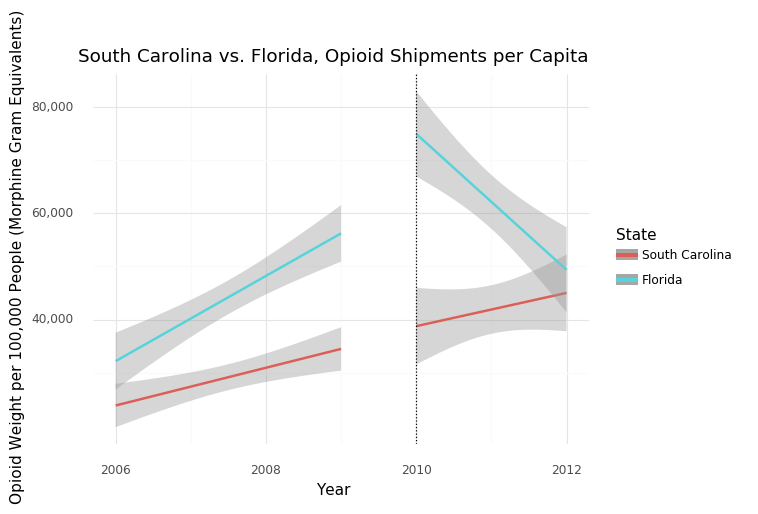

<ggplot: (8781458152525)>


In [467]:
# run a loop to generate DiD comparisons to Florida
pltList = []

for number in range(len(FL_df_pre)):
    p = (
        ggplot()
        + geom_smooth(
            FL_df_pre[number],
            aes(x="Year", y="PerCapWeight", color="State"),
            method="lm",
        )
        + geom_smooth(
            FL_df_post[number],
            aes(x="Year", y="PerCapWeight", color="State"),
            method="lm",
        )
        + geom_smooth(
            FL_pre,
            aes(x="Year", y="PerCapWeight", color="State"),
            method="lm",
        )
        + geom_smooth(
            FL_post,
            aes(x="Year", y="PerCapWeight", color="State"),
            method="lm",
        )
        + geom_vline(xintercept=FL_policy_year, linetype="dotted")
        + xlab("Year")
        + ylab("Opioid Weight per 100,000 People (Morphine Gram Equivalents)")
        + theme_minimal()
        + scale_x_continuous(breaks=[2006, 2008, 2010, 2012], limits=[2006, 2012])
        + labs(title=titles[number] + " vs. Florida, Opioid Shipments per Capita")
        + scale_y_continuous(
            breaks=[40000, 60000, 80000], labels=["40,000", "60,000", "80,000"]
        )
    )
    name = "Opioid Shipment: FL " + titles[number]
    ggsave(
        plot=p,
        filename=name,
        path="/Users/samsloate/Desktop/Data_Science/Opioids_Project/estimating-impact-of-opioids-2020-purlple-team/30_results/FL_DID",
    )
    print(p)

In [ ]:
    pltList.append(p)

    name = "FL " + titles[number]

    ggsave(
        plot=p,
        filename=name,
        path="/Users/samsloate/Desktop/Data_Science/Opioids_Project/estimating-impact-of-opioids-2020-purlple-team/30_results/FL_DID",
    